In [1]:
import csv
import re
#import emoji
import os
from datetime import datetime
import logging
import torch
from tensorflow import keras
from keras.utils import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertForSequenceClassification, AdamW, BertConfig
from tqdm import tqdm, trange
import numpy as np
import time
import random
import pandas as pd 
import datetime
from _datetime import datetime as dt
from sklearn.metrics import classification_report
from transformers import AutoModel, AutoTokenizer, AutoModelWithLMHead
from sklearn.model_selection import train_test_split
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

/anaconda/envs/hate/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-05 07:11:27.322851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 07:11:52.344739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-05 07:11:52.344850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
df = pd.read_csv("../Data/abuseval_offenseval_train_tweets.tsv")
df1=pd.read_csv("../Data/ABUSE_EVAL/abuseval_offenseval_test_tweets.tsv")
df2=pd.read_csv("../Data/Hate_NAACL/NAACL_SRW_2016_tweetsintl.tsv")
df3=pd.read_csv("../Data/Hate_OLID/olid-training-v1.0.tsv",sep="\t")
df3=df3[['tweet','subtask_a']]
df3=df3.rename(columns={'tweet':'Tweets','subtask_a':'Labels'})
df4=pd.read_csv("../Data/icwsmlabeled_datahate.csv")
df4=df4[['tweet','class']]
df4=df4.rename(columns={'tweet':'Tweets','class':'Labels'})
    #train_df2=pd.read_csv("Data/Hate_NAACL/NAACL_SRW_2016_tweetsintl.tsv")

df['Labels']=df['Labels'].replace({'NOTABU':0,'EXP':1,'IMP':1})
df3["Labels"]=df3['Labels'].replace({'NOT':0,'OFF':1})
df4["Labels"]=df4['Labels'].replace({0:1,2:0})
df2["Labels"]=df2['Labels'].replace({2:1})
df5 = pd.concat([df,df1,df2,df3,df4], ignore_index=True, sort=False)
df5=df5.dropna()
df5['Labels']=pd.to_numeric(df5['Labels'])
#df6=pd.read_csv("../Data/BalanceHateData.csv")
#df6=df6.dropna()
#df5=pd.read_csv("Data/fakereviewdatasets/combinedfakedata.csv")
Data=[]
count=0
Label=[]
for i,j in zip(list(df5['Tweets']),df5['Labels']):
    full_line = i
    full_line = re.sub(r'#([^ ]*)', r'\1', full_line)
    full_line = re.sub(r'https.*[^ ]', 'URL', full_line)
    full_line = re.sub(r'http.*[^ ]', 'URL', full_line)
    #full_line = emoji.demojize(full_line)
    full_line = re.sub(r'(:.*?:)', r' \1 ', full_line)
    full_line = re.sub(' +', ' ', full_line)
    full_line=re.sub("\s\s+" , " ", full_line)
    full_line = re.sub( '[^a-zA-Z]', ' ', full_line)
    if len(list(full_line.split()))>1:
            #print(f'{count}.{full_line}')
        Data.append(full_line)
        Label.append(j)
#Label=list(df5['Labels'])

random_seed = 12342
x_train_val, x_test, y_train_val, y_test = train_test_split(Data, Label, shuffle=True, test_size = 0.1, random_state=random_seed, stratify=Label)
    #x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, shuffle=True, test_size = 0.1, random_state=random_seed, stratify=y_train_val)
#train_tweets=x_train_val
test_tweets=x_test
#train_labels=y_train_val
test_labels=y_test

In [3]:
df6['Labels'].value_counts()

NameError: name 'df6' is not defined

In [4]:
#Total no. tweets=1848
#EXPLICIT=291
#IMPLICIT=121
sns.countplot(x='Labels' , data = df)

NameError: name 'sns' is not defined

<AxesSubplot: xlabel='Labels', ylabel='count'>

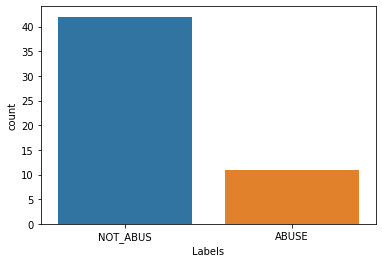

In [33]:
#Total no. tweets=53
#NOT_ABUS = 42
#ABUSE    =11
sns.countplot(x='Labels' , data = df1)

In [7]:
import logging
logging.basicConfig(level=logging.ERROR)

<AxesSubplot: xlabel='Labels', ylabel='count'>

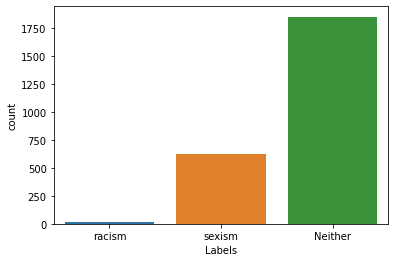

In [34]:
#Total no. tweets=2493
#Neither=1855
#sexism=626
#racism=12
sns.countplot(x='Labels' , data = df2)

<AxesSubplot: xlabel='Labels', ylabel='count'>

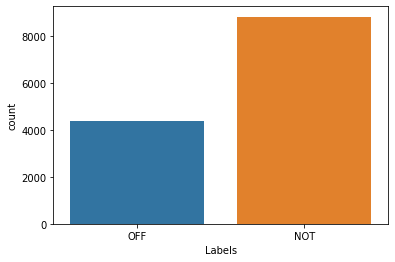

In [36]:
#Total no. tweets=13240
#NOT=8840
#OFF=4400
sns.countplot(x='Labels' , data = df3)

<AxesSubplot: xlabel='Labels', ylabel='count'>

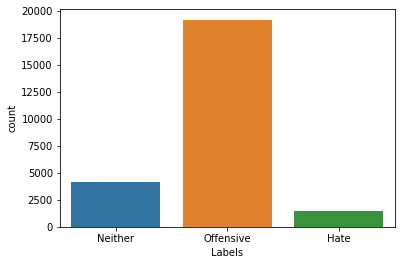

In [39]:
#Total no. tweets=24783
#Offensive=19190
#Neither=4163
#Hate=1430
sns.countplot(x='Labels' , data = df4)

In [1]:
import pandas as pd
import seaborn as sns
df=pd.read_csv("../../Data/BalanceHateData.csv")
sns.countplot(x='Labels' , data = df)

ModuleNotFoundError: No module named 'seaborn'

<AxesSubplot: xlabel='Labels', ylabel='count'>

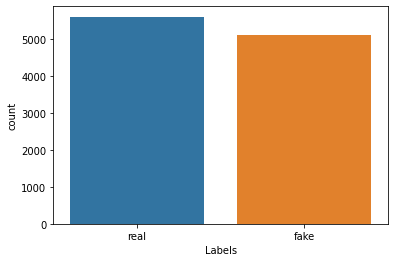

In [40]:
#Total no. tweets=10700
#real=5600
#fake=5100
sns.countplot(x='Labels' , data = df6)

<AxesSubplot: >

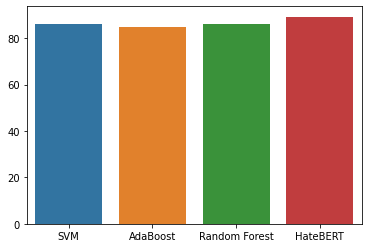

In [5]:
import seaborn as sns
F1_score=[84,82,85,89.22]
Accuracy=[86,85,86,89.22]
Recall=[76,73,78,91.28]
Methods=['SVM','AdaBoost','Random Forest','HateBERT']
sns.barplot(x=Methods,y=Accuracy)


<AxesSubplot: >

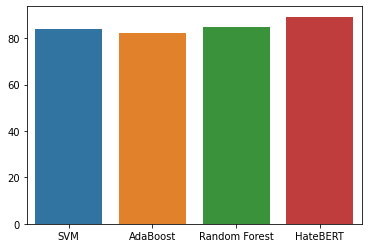

In [6]:
import seaborn as sns
F1_score=[84,82,85,89.22]
Accuracy=[86,85,86,89.22]
Recall=[76,73,78,91.28]
Methods=['SVM','AdaBoost','Random Forest','HateBERT']
sns.barplot(x=Methods,y=F1_score)

In [3]:
def load_train_test_data1(tokenizer,Text):
    Data=[]
    count=0
    Label=[]
    for i in Text:
        #print (i)
        full_line = str(i)
        #full_line = re.sub(r'#([^ ]*)', r'\1', full_line)
        full_line = re.sub(r'https.*[^ ]', 'URL', full_line)
        full_line = re.sub(r'http.*[^ ]', 'URL', full_line)
        #full_line = emoji.demojize(full_line)
        full_line = re.sub(r'(:.*?:full_line)', r' \1 ', full_line)
        full_line = re.sub(' +', ' ', full_line)
        full_line=re.sub("\s\s+" , " ", full_line)
        full_line = re.sub( '[^a-zA-Z]', ' ', full_line)
        #if len(list(full_line.split()))>1:
            #print(f'{count}.{full_line}')
        Data.append(full_line)
#Label=list(df5['Labels'])

    
    test_tweets=Data
    # List of all tokenized tweets
    test_input_ids = []

    # For every tweet in the test set
    for sent in test_tweets:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=100, # orignal value 512 - change Tommaso
            truncation=True
            # This function also supports truncation and conversion
            # to pytorch tensors, but we need to do padding, so we
            # can't use these features :( .
            # max_length = 128,          # Truncate all sentences.
            # return_tensors = 'pt',     # Return pytorch tensors.
        )

        # Add the encoded tweet to the list.
        test_input_ids.append(encoded_sent)

    # # Pad our input tokens with value 0.
    # # "post" indicates that we want to pad and truncate at the end of the sequence,
    # # as opposed to the beginning.

    test_input_ids = pad_sequences(test_input_ids, maxlen=100, dtype="long",
                                    value=tokenizer.pad_token_id, truncating="pre", padding="pre")



    # Create attention masks
    # The attention mask simply makes it explicit which tokens are actual words versus which are padding
    test_attention_masks = []

    # For each tweet in the test set
    for sent in test_input_ids:
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]

        # Store the attention mask for this sentence.
        test_attention_masks.append(att_mask)

    # Return the list of encoded tweets, the list of labels and the list of attention masks
    return  test_input_ids, test_attention_masks

In [7]:
import pandas as pd
from sklearn.metrics import confusion_matrix
# Input language, is used just for paths
#language = 'tr'

#model_dir='../Data/2023-01-04_Covidtweets'

def main(Text):
    model_dir='../Data/2022-12-29_Hatedata'
    #model_dir='../Data/2023-01-30_BalHatedata'
    #model_dir='../Data/2023-01-31_balsexismbinary'
    #model_dir='../Data/2023-01-31_sexism'
    #model_dir='../Data/2023-01-31_fineHateBERTsexism'
# -----------------------------
# Load Pre-trained BERT model
# -----------------------------
#config_class, model_class, tokenizer_class = (BertConfig, BertForSequenceClassification, BertTokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load a trained model and vocabulary pre-trained for specific language
#logger.info("Loading model") #from: '" + model_dir + "', it may take a while...")

# Load pre-trained Tokenizer from directory, change this to load a tokenizer from ber package
    tokenizer = BertTokenizer.from_pretrained(model_dir)

# Load a trained model and vocabulary that you have fine-tuned
    model = BertForSequenceClassification.from_pretrained(model_dir)
#tokenizer = tokenizer_class.from_pretrained(model_dir)

# Copy the model to the GPU.
    model.to(device)

# Set the model to work on CPU if no GPU is present
    model.to(device)
#logger.info("HateBERT for classification model has been loaded!")


# --------------------------------------------------------------------
# ---------- Print BERT model list of parameters and layers ----------
# --------------------------------------------------------------------
# The list of prints can be safely removed

# Get all of the model's parameters as a list of tuples.
    params = list(model.named_parameters())

    validation_inputs, validation_masks = load_train_test_data1(tokenizer,Text)


# Tweets
    validation_inputs = torch.tensor(validation_inputs)

# Labels
#validation_labels = torch.tensor(validation_labels)

# Attention masks
    validation_masks = torch.tensor(validation_masks)

# We will use a DataLoader, it helps save on memory during training because, unlike a for loop, with an iterator
# the entire dataset does not need to be loaded into memory
# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

    batch_size = 1

# Create the DataLoader for our validation set.
#validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_data = TensorDataset(validation_inputs, validation_masks)
    validation_sampler = SequentialSampler(validation_data)
# Note that the number of batch has to be the same, this means that we have to aggregate results in the end
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



# Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store true lables for global eval
    gold_labels = []
    # Store  predicted labels for global eval
    predicted_labels = []

    #logger.info("")
    #logger.info("Running Validation...")
#print ("Running Validation...")
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
#for t in validation_dataloader:
        # Add batch to GPU/CPU
        batch = tuple(t.to(device) for t in batch)
    #batch=tuple(t.to(device))

        # Unpack the inputs from our dataloader
    #b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
    #label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
    #tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
    #eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
    #nb_eval_steps += 1
        #print (logits[0])
        pred_flat = np.argmax(logits, axis=1).flatten()
    #labels_flat = label_ids.flatten()

       # Store gold labels single list
    #gold_labels.extend(labels_flat)
        # Store predicted labels single list
        predicted_labels.extend(pred_flat)
    label_names=[]
    for i in predicted_labels:
        if (i==0):
            label_names.append("not hate")
            print ("not hate")
        else:
            label_names.append("hate")
            print ("hate")
#print (predicted_labels[0])
    return label_names


In [5]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch
# Input language, is used just for paths
#language = 'tr'

#model_dir='../Data/2023-01-04_Covidtweets'

def main(Text):
    model_dir='../Data/2022-12-29_Hatedata'
    #model_dir='../Data/2023-01-31_balsexismbinary'
    #model_dir='../Data/2023-01-31_sexism'
    #model_dir='../Data/2023-01-31_fineHateBERTsexism'
    # model_dir='../Shared_task/2023-01-31_13_multiple_sex'
# -----------------------------
# Load Pre-trained BERT model
# -----------------------------
#config_class, model_class, tokenizer_class = (BertConfig, BertForSequenceClassification, BertTokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load a trained model and vocabulary pre-trained for specific language
#logger.info("Loading model") #from: '" + model_dir + "', it may take a while...")

# Load pre-trained Tokenizer from directory, change this to load a tokenizer from ber package
    tokenizer = BertTokenizer.from_pretrained(model_dir)

# Load a trained model and vocabulary that you have fine-tuned
    model = BertForSequenceClassification.from_pretrained(model_dir)
#tokenizer = tokenizer_class.from_pretrained(model_dir)

# Copy the model to the GPU.
    model.to(device)

# Set the model to work on CPU if no GPU is present
    model.to(device)
#logger.info("HateBERT for classification model has been loaded!")


# --------------------------------------------------------------------
# ---------- Print BERT model list of parameters and layers ----------
# --------------------------------------------------------------------
# The list of prints can be safely removed

# Get all of the model's parameters as a list of tuples.
    params = list(model.named_parameters())

    validation_inputs, validation_masks = load_train_test_data1(tokenizer,Text)


# Tweets
    validation_inputs = torch.tensor(validation_inputs)

# Labels
#validation_labels = torch.tensor(validation_labels)

# Attention masks
    validation_masks = torch.tensor(validation_masks)

# We will use a DataLoader, it helps save on memory during training because, unlike a for loop, with an iterator
# the entire dataset does not need to be loaded into memory
# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

    batch_size = 1

# Create the DataLoader for our validation set.
#validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_data = TensorDataset(validation_inputs, validation_masks)
    validation_sampler = SequentialSampler(validation_data)
# Note that the number of batch has to be the same, this means that we have to aggregate results in the end
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



# Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store true lables for global eval
    gold_labels = []
    # Store  predicted labels for global eval
    predicted_labels = []

    #logger.info("")
    #logger.info("Running Validation...")
#print ("Running Validation...")
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
#for t in validation_dataloader:
        # Add batch to GPU/CPU
        batch = tuple(t.to(device) for t in batch)
    #batch=tuple(t.to(device))

        # Unpack the inputs from our dataloader
    #b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
    #label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
    #tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
    #eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
    #nb_eval_steps += 1
        #print (logits[0])
        pred_flat = np.argmax(logits, axis=1).flatten()
    #labels_flat = label_ids.flatten()

       # Store gold labels single list
    #gold_labels.extend(labels_flat)
        # Store predicted labels single list
        predicted_labels.extend(pred_flat)
    label_names=[]
    for i in predicted_labels:
        if (i==0):
            label_names.append("1. threats, plans to harm and incitement")
            print ("1. threats, plans to harm and incitement")
        elif(i==1):
            label_names.append("2. derogation")
            print ("2. derogation")
        elif(i==2):
            label_names.append("3. animosity")
            print ("3. animosity")
        else:
            label_names.append("4. prejudiced discussions")
            print ("4. prejudiced discussions")
#print (predicted_labels[0])
    return label_names


In [3]:
import pandas as pd
df=pd.read_csv("../../Data/TestingData.csv")

In [84]:
import pandas as pd 
df=pd.read_csv("../Shared_task/test_task_a_entries.csv")
df=pd.read_csv("../Shared_task/test_task_b_entries.csv")

In [5]:
df.head()

,Tweet,Label
0,@USER you have the best booty and everything y...,NOT
1,@USER Right.!!!! I don't know what the hell he...,NOT
2,RT @Adogg_34: @viva_based stealing a car and f...,Offensive
3,Idk why bitches think they players lol bitches...,Offensive
4,1. Killshot 2. Gun control 3. Rap devil,NOT


In [9]:
Text=["I’m in the mood to punch a Muslim, who’s with me?", 
"I hope you get COVID and die.",
"all hindus are sadists"]
#Text=["Her height will b reduced 6 inch from top before amrinder reaches her to arrest. She is sick. She needs treatment. And she is alive becoz she muslim. Don't blabber non sense"]
#Text=['USER EVERYTHING is an issue with Teja..go live in another country like Iran..']
#Text=['@USER @USER He is not a Dalit or a muslim no need to remember']
#Text=["@USER @USER @USER Tell this idiot to try with other religion book. Her height will b reduced 6 inch from top before amrinder reaches her to arrest. She is sick. She needs treatment. Don't blabber non sense"]
y_pred=main(Text)

hate
hate
hate


In [6]:
y_pred

['@USER @USER He is not a Dalit or a brahmins no need to remember']

In [87]:
df['label_pred']=y_pred

In [51]:
df['label_pred']=df['label_pred'].replace({0:"not sexist",1:"sexist"})

In [88]:
df=df[["rewire_id","label_pred"]]

In [89]:
df.head()

,rewire_id,label_pred
0,sexism2022_english-10731,2. derogation
1,sexism2022_english-7356,3. animosity
2,sexism2022_english-13064,4. prejudiced discussions
3,sexism2022_english-17039,3. animosity
4,sexism2022_english-14482,3. animosity


In [90]:
df.to_csv("../Shared_task/taskbresultstest.csv",index=False)

In [82]:
! zip -r taskaresultdev.zip ../Shared_task/taskaresultsdev.csv

  adding: ../Shared_task/taskaresultsdev.csv (deflated 90%)


In [38]:

def data_preprocess(Text, label):
    Data=[]
    Label=[]
    for i,j in zip(Text,label):
            #print (i)
        full_line = str(i)
            #full_line = re.sub(r'#([^ ]*)', r'\1', full_line)
        full_line = re.sub(r'https.*[^ ]', 'URL', full_line)
        full_line = re.sub(r'http.*[^ ]', 'URL', full_line)
        #full_line = emoji.demojize(full_line)
        full_line = re.sub(r'(:.*?:full_line)', r' \1 ', full_line)
        full_line = re.sub(' +', ' ', full_line)
        full_line=re.sub("\s\s+" , " ", full_line)
        full_line = re.sub( '[^a-zA-Z]', ' ', full_line)
        if len(list(full_line.split()))>1:
                #print(f'{count}.{full_line}')
            Data.append(full_line)
            Label.append(j)
    return Data, Label
        

In [39]:
Text,Label=data_preprocess(df['Tweet'],df['Label'])

In [43]:
df6=pd.DataFrame({"Tweets":Text,"Labels":Label})

In [44]:
Predict=main(df6["Tweets"])

[-0.5088372   0.96910447]
[-0.14484508  0.5584836 ]
[-3.6942778  4.381621 ]
[-3.7444854  4.4237976]
[ 0.8135058 -0.6003645]
[-1.8272264  2.6191022]
[-3.5707493  4.236178 ]
[-1.5125523  2.1425781]
[-1.5416979  2.329188 ]
[-2.5923374  3.2673745]
[-1.9657753  2.757134 ]
[ 2.4875796 -2.7957203]
[ 2.5207803 -2.6235712]
[-3.2620468  3.9473755]
[ 2.4099693 -2.3793757]
[-3.7521043  4.3550587]
[-3.7536235  4.39691  ]
[-3.6201665  4.262936 ]
[-3.6220584  4.3088975]
[-3.4994295  4.014184 ]
[-1.7976278  2.2674115]
[-3.305381   4.0134416]
[ 1.4919654 -1.1748489]
[-3.692905   4.3078423]
[-0.74632925  1.1280212 ]
[ 2.3248522 -2.426176 ]
[ 2.6108375 -2.9914718]
[-2.5851421  3.3792274]
[-1.474501   2.0786698]
[-3.6078122  4.197494 ]
[-3.1542082  3.7686687]
[ 2.2589374 -2.3448143]
[ 1.7310892 -1.666014 ]
[-3.5809371  4.270004 ]
[-3.0074325  3.5690618]
[ 2.6608183 -2.817017 ]
[-3.1129882  3.8556728]
[-3.6028087  4.1482263]
[ 3.0092325 -3.2115989]
[ 2.7496738 -2.8302598]
[ 1.3742045 -1.3726846]
[ 2.390459

In [45]:
df6["Prediction"]=Predict

In [49]:
df6.to_csv("../../Data/TestingData1.csv")

In [48]:
df6.head()

,Tweets,Labels,Prediction
0,USER you have the best booty and everything y...,NOT,1
1,USER Right I don t know what the hell he...,NOT,1
2,RT Adogg viva based stealing a car and f...,Offensive,1
3,Idk why bitches think they players lol bitches...,Offensive,1
4,Killshot Gun control Rap devil,NOT,0


In [30]:
df['Tweet'][80:90]

80    RT @daishialopez: I don't watch the VS fashion...
81    http://t.co/flERluQXq4 @molliejones_ i'm not s...
82                    @USER Aww Bradley you are so cute
83    @USER @USER How did the press" get the letter?...
84    @USER @USER Common sense gun control" would in...
85    "@KnightfanNeal #UCFPINKPARTY come on stay ali...
86    &#9733;@&#9733;@&#9733;@&#9733;@&#9733; GRAND ...
87                                @AbrehamDadi no bitch
88    @USER But the wicked  like the troubled sea, w...
89    RT @TayWest: When hoes call other hoes "hoes" ...
Name: Tweet, dtype: object

In [10]:
Labels=[]
for i in df['Tweet'][:100]:
    print (main(i))


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [11]:
df['Tweet']=df['Tweet'].dropna()

In [13]:
df['Tweet'][:100]

0     @USER you have the best booty and everything y...
1     @USER Right.!!!! I don't know what the hell he...
2     RT @Adogg_34: @viva_based stealing a car and f...
3     Idk why bitches think they players lol bitches...
4               1. Killshot 2. Gun control 3. Rap devil
                            ...                        
95    @USER @USER Sounds to me like the Pope needs c...
96    @trix2343 I have something that you don't bitc...
97    @USER @USER @USER @USER @USER @USER @USER Funn...
98    @USER @USER @USER @USER @USER @USER @USER @USE...
99    &#8220;@_TheCrownedHead: what if I tell y'all ...
Name: Tweet, Length: 100, dtype: object

In [8]:
df=df.dropna()

In [9]:
df.shape

(4242, 2)

In [8]:
df['Tweet'][:100].shape

(100,)

In [6]:
len(y_pred)

4218

In [9]:
y_pred=[]
for i in df['Label']:
    pred=main(i)
    y_pred.append(pred)

In [5]:
y_pred=main(df['Label'])

[ 1.978082  -1.9548558]
[ 1.978082  -1.9548558]
[ 1.978082  -1.9548558]
[ 1.978082  -1.9548558]
Non-Hate
Non-Hate
Non-Hate
Non-Hate


In [6]:
len(y_pred)

4

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1626
           1       0.91      0.91      0.91      2603

    accuracy                           0.89      4229
   macro avg       0.89      0.89      0.89      4229
weighted avg       0.89      0.89      0.89      4229



In [13]:

main(data["Tweet"])

Hate
Hate
Hate
Hate
Non-Hate
Hate
Hate
Hate
Hate
Hate
Hate
Non-Hate
Non-Hate
Hate
Non-Hate
Hate
Hate
Hate
Hate
Hate
Hate
Hate
Non-Hate
Hate
Hate
Non-Hate
Non-Hate
Hate
Hate
Hate
Hate
Non-Hate
Non-Hate
Hate
Hate
Non-Hate
Hate
Hate
Non-Hate
Non-Hate
Non-Hate
Non-Hate
Hate
Non-Hate
Non-Hate
Non-Hate
Non-Hate
Hate
Hate
Non-Hate
Non-Hate
Hate
Hate
Hate
Non-Hate
Non-Hate
Non-Hate
Non-Hate
Hate
Hate
Hate
Non-Hate
Hate
Hate
Non-Hate
Hate
Hate
Non-Hate
Hate
Non-Hate
Hate
Hate
Hate
Hate
Hate
Hate
Non-Hate
Hate
Hate
Non-Hate
Hate
Non-Hate
Non-Hate
Non-Hate
Non-Hate
Non-Hate
Hate
Non-Hate
Hate
Hate
Hate
Hate
Hate
Non-Hate
Non-Hate
Hate
Non-Hate
Non-Hate
Hate
Hate
Non-Hate
Hate
Non-Hate
Non-Hate
Non-Hate
Hate
Hate
Hate
Non-Hate
Hate
Hate
Hate
Hate
Non-Hate
Non-Hate
Non-Hate
Non-Hate
Hate
Hate
Hate
Non-Hate
Hate
Non-Hate
Non-Hate
Hate
Hate
Non-Hate
Non-Hate
Hate
Hate
Hate
Hate
Non-Hate
Hate
Non-Hate
Non-Hate
Hate
Hate
Hate
Non-Hate
Hate
Hate
Non-Hate
Non-Hate
Non-Hate
Hate
Hate
Non-Hate
Non-Hate
Hat

In [5]:
Text=["If you go to a muslim store, you are supporting those muslim, let’s stop giving our money to these muslim"]
main(Text)

NameError: name 'torch' is not defined

In [7]:
import pandas as pd
data=pd.read_csv("../../Data/TestingData.csv")

In [8]:
data.head()

,Tweet,Label
0,@USER you have the best booty and everything y...,NOT
1,@USER Right.!!!! I don't know what the hell he...,NOT
2,RT @Adogg_34: @viva_based stealing a car and f...,Offensive
3,Idk why bitches think they players lol bitches...,Offensive
4,1. Killshot 2. Gun control 3. Rap devil,NOT


In [ ]:
Fake Covid data prototype

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix
# Input language, is used just for paths
#language = 'tr'
Text=["@USER She should ask a few native Americans what their take on this is.","@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL","Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT","@USER Someone should'veTaken this piece of shit to a volcano. 😂"]

Text=['#IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh3ZxknnhZ','The hypochondriac’s guide to convincing yourself you’ve got COVID-19 https://t.co/BpEl1mN97h https://t.co/7kGVgcPxCP']
model_dir='../Data/2023-01-04_Covidtweets'
#model_dir='../Data/2022-12-29_Hatedata'
# -----------------------------
# Load Pre-trained BERT model
# -----------------------------
#config_class, model_class, tokenizer_class = (BertConfig, BertForSequenceClassification, BertTokenizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load a trained model and vocabulary pre-trained for specific language
#logger.info("Loading model") #from: '" + model_dir + "', it may take a while...")

# Load pre-trained Tokenizer from directory, change this to load a tokenizer from ber package
tokenizer = BertTokenizer.from_pretrained(model_dir)

# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(model_dir)
#tokenizer = tokenizer_class.from_pretrained(model_dir)

# Copy the model to the GPU.
model.to(device)

# Set the model to work on CPU if no GPU is present
model.to(device)
#logger.info("HateBERT for classification model has been loaded!")


# --------------------------------------------------------------------
# ---------- Print BERT model list of parameters and layers ----------
# --------------------------------------------------------------------
# The list of prints can be safely removed

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

validation_inputs, validation_masks = load_train_test_data1(tokenizer,Text)


# Tweets
validation_inputs = torch.tensor(validation_inputs)

# Labels
#validation_labels = torch.tensor(validation_labels)

# Attention masks
validation_masks = torch.tensor(validation_masks)

# We will use a DataLoader, it helps save on memory during training because, unlike a for loop, with an iterator
# the entire dataset does not need to be loaded into memory
# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 1

# Create the DataLoader for our validation set.
#validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_data = TensorDataset(validation_inputs, validation_masks)
validation_sampler = SequentialSampler(validation_data)
# Note that the number of batch has to be the same, this means that we have to aggregate results in the end
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

    # Store true lables for global eval
gold_labels = []
    # Store  predicted labels for global eval
predicted_labels = []

    #logger.info("")
    #logger.info("Running Validation...")
#print ("Running Validation...")
t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
model.eval()

    # Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
for batch in validation_dataloader:
#for t in validation_dataloader:
        # Add batch to GPU/CPU
    batch = tuple(t.to(device) for t in batch)
    #batch=tuple(t.to(device))

        # Unpack the inputs from our dataloader
    #b_input_ids, b_input_mask, b_labels = batch
    b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
    with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
    logits = outputs[0]

        # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    #label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
    #tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
    #eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
    #nb_eval_steps += 1

    pred_flat = np.argmax(logits, axis=1).flatten()
    #labels_flat = label_ids.flatten()

       # Store gold labels single list
    #gold_labels.extend(labels_flat)
        # Store predicted labels single list
    predicted_labels.extend(pred_flat)
for i in predicted_labels:
    if (i==0):
        print ("Real")
    else:
        print ("Fake")
#print (predicted_labels[0])


Real
Fake


In [1]:
!conda list --explicit > conda.yml


In [2]:
!conda env create -f conda.yml


Retrieving notices: ...working... done

# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/Users/centific/anaconda3/lib/python3.11/site-packages/conda/exception_handler.py", line 17, in __call__
        return func(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^
      File "/Users/centific/anaconda3/lib/python3.11/site-packages/conda_env/cli/main.py", line 56, in do_call
        exit_code = getattr(module, func_name)(arguments, parser)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      File "/Users/centific/anaconda3/lib/python3.11/site-packages/conda/notices/core.py", line 119, in wrapper
        return_value = func(*args, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^
      File "/Users/centific/anaconda3/lib/python3.11/site-packages/conda_env/cli/main_create.py", line 105, in execute
        spec = specs.detect(
               ^^^^^^^^^^^^^
      File "/Users/centific/anaconda3/lib/pyth

In [3]:
!pip list

Package                        Version
------------------------------ --------------------
absl-py                        2.0.0
adversarial-robustness-toolbox 1.16.0
aiobotocore                    2.4.2
aiofiles                       22.1.0
aiohttp                        3.8.3
aioitertools                   0.7.1
aiosignal                      1.2.0
aiosqlite                      0.18.0
alabaster                      0.7.12
albumentations                 1.3.1
anaconda-catalogs              0.2.0
anaconda-client                1.11.3
anaconda-navigator             2.4.2
anaconda-project               0.11.1
anyio                          3.5.0
appdirs                        1.4.4
applaunchservices              0.3.0
appnope                        0.1.2
appscript                      1.1.2
argon2-cffi                    21.3.0
argon2-cffi-bindings           21.2.0
arrow                          1.2.3
astroid                        2.14.2
astropy                        5.1
asttokens     